In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [10]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
# 100장만 이용(총 60000장)
z_dim = 100

### 생성자 구현

In [10]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape(img_shape))

    return model

### 판별자 구현

In [10]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))

    return model

### GAN 모델 생성

In [10]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    return model

### 학습

* 실제 MNIST 이미지를 load 하는데, 라벨 데이터와 테스트 데이터는 필요하지 않으므로 X_train만 가져온다.
* MNIST 이미지는 0 ~ 255 사이의 값으로 이루어져 있는데, keras에 넣으려면 -1 ~ 1 값으로 변경해야 한다.
* 또한 2차원 이미지를 여러 장 넣을 것이므로 2차원을 3차원으로 확장한다.

11501568/11490434 [==============================] - 1s 0us/step
1000 [D loss: 0.070703, acc.: 99.22%] [G loss: 3.714702]
2000 [D loss: 0.070093, acc.: 97.66%] [G loss: 4.697149]
3000 [D loss: 0.045483, acc.: 98.83%] [G loss: 5.293956]
4000 [D loss: 0.129294, acc.: 95.31%] [G loss: 6.213028]
5000 [D loss: 0.443387, acc.: 84.38%] [G loss: 4.321459]
6000 [D loss: 0.317508, acc.: 87.89%] [G loss: 3.737624]
7000 [D loss: 0.177985, acc.: 93.36%] [G loss: 4.423173]
8000 [D loss: 0.226225, acc.: 91.41%] [G loss: 5.541323]
9000 [D loss: 0.385535, acc.: 80.86%] [G loss: 2.827848]
10000 [D loss: 0.317994, acc.: 83.98%] [G loss: 3.882335]


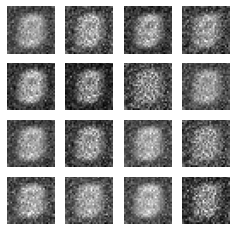

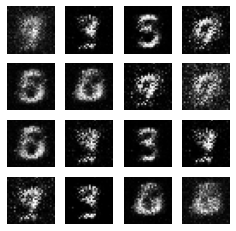

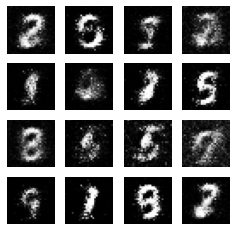

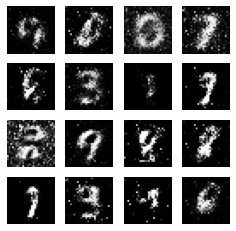

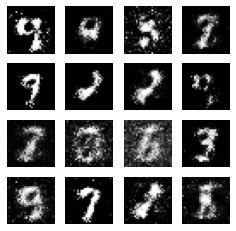

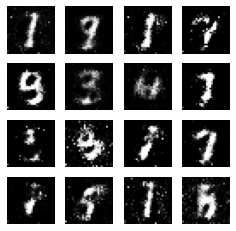

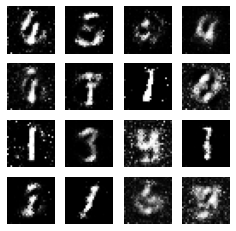

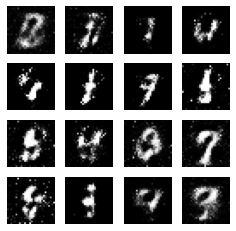

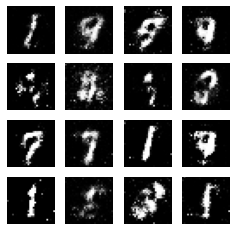

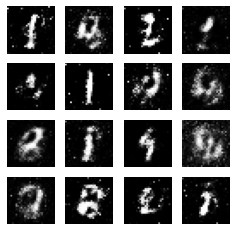

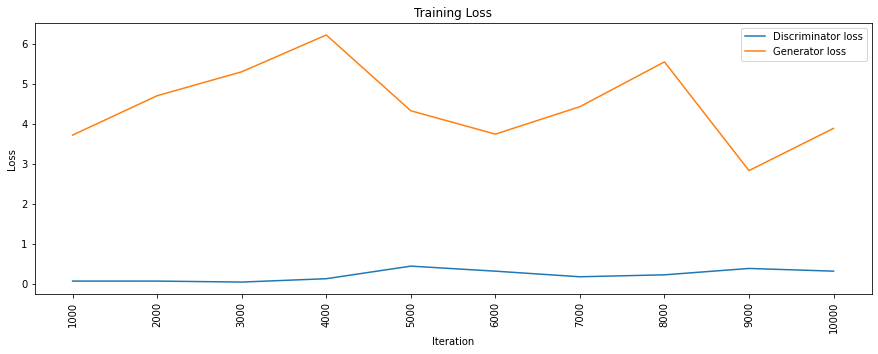

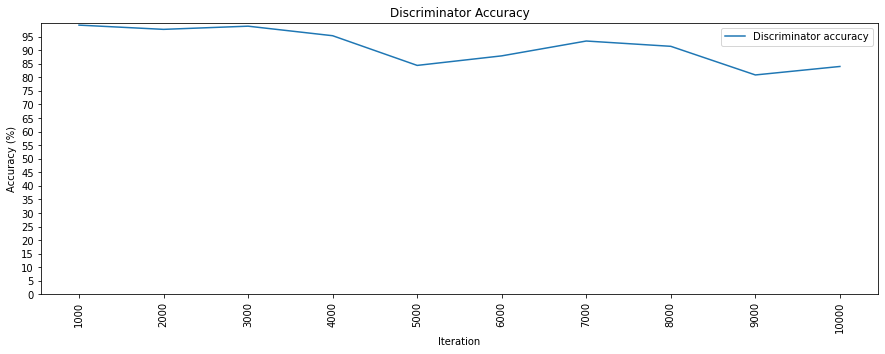

In [10]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer="adam",
                      metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer="adam")

losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()

    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        # np.random.normal(평균, 표준편차, 데이터 개수) : 정규분포 만들기
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        z = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            sample_images(generator)


def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1


iterations = 10000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

losses = np.array(losses)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

accuracies = np.array(accuracies)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [11]:
from tensorflow.keras import backend as K

K.clear_session()

from numba import cuda
cuda.select_device(0)
cuda.close()